In [2]:
# importing libraries

import time
import os
import cv2
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [1]:
!pip install torchsummary


In [3]:
# Define the root paths to your data
train_imgs_path = '/kaggle/input/eye-disease-oct/train/train'
val_imgs_path = '/kaggle/input/eye-disease-oct/validation/validation'
test_imgs_path = '/kaggle/input/eye-disease-oct/test/test'

In [4]:
len(os.listdir(os.path.join(train_imgs_path,'CNV')))

5000

In [5]:
len(os.listdir(os.path.join(val_imgs_path,'CNV')))

1000

### Augmentations

In [6]:
image_transforms = {
    'train': A.Compose([
        A.Resize(64, 64),
        A.HorizontalFlip(p=0.3),  # Horizontal flip with 50% probability
        A.Rotate(limit=30),  # Random rotation up to 30 degrees
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(64, 64),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2(),
    ]),
    'test': A.Compose([
        A.Resize(64, 64),
        A.Normalize(mean=[0.5], std=[0.5]),
        ToTensorV2(),
    ]),
}


### Creating my own Imgfolder

In [7]:
class Custome_Img_Folder(Dataset):
  def __init__(self,root_dir,transform = None):
    super(Custome_Img_Folder,self).__init__()
    self.data = []
    self.root_dir = root_dir
    self.classes = os.listdir(root_dir)
    self.transform = transform

    for i , name in enumerate(self.classes):
      all_files = os.listdir(os.path.join(root_dir,name))
      for file in tqdm(all_files,desc=f"loading {name}"):
        image = np.array(Image.open(os.path.join(root_dir,name,file)))
        self.data.append((image,i))



  def __len__(self):
    return len(self.data)


  def __getitem__(self,i):
    image , label = self.data[i]
    if self.transform is not None:
      augs = self.transform(image=image)
      image = augs["image"]

    return image , label

In [8]:
train_dataset = Custome_Img_Folder(root_dir=train_imgs_path,transform=image_transforms['train'])

loading DME: 100%|██████████| 5000/5000 [00:40<00:00, 124.85it/s]


In [9]:
valid_dataset = Custome_Img_Folder(root_dir=val_imgs_path,transform=image_transforms['val'])

loading DME: 100%|██████████| 1000/1000 [00:07<00:00, 142.53it/s]


In [49]:
train_dataset.classes

['DRUSEN', 'CNV', 'NORMAL', 'DME']

In [50]:
valid_dataset.classes

['DRUSEN', 'CNV', 'NORMAL', 'DME']

In [10]:
train_samples = len(train_dataset)
train_samples

20000

In [11]:
valid_samples = len(valid_dataset)
valid_samples

4000

### Making Loaders

In [12]:
batch_size = 32
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle = True,drop_last=True)
valid_loader = DataLoader(valid_dataset,batch_size = batch_size,shuffle = True,drop_last=True)


### Displaying Some of the images

In [13]:
def show_images(images, labels, class_names):
    num_rows = 4
    num_cols = 8
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            ax = axes[i, j]
            ax.imshow(images[index].permute(1, 2, 0))
            ax.set_title(class_names[labels[index].item()])
            ax.axis('off')

    plt.tight_layout()
    plt.show()

torch.Size([32, 1, 64, 64])


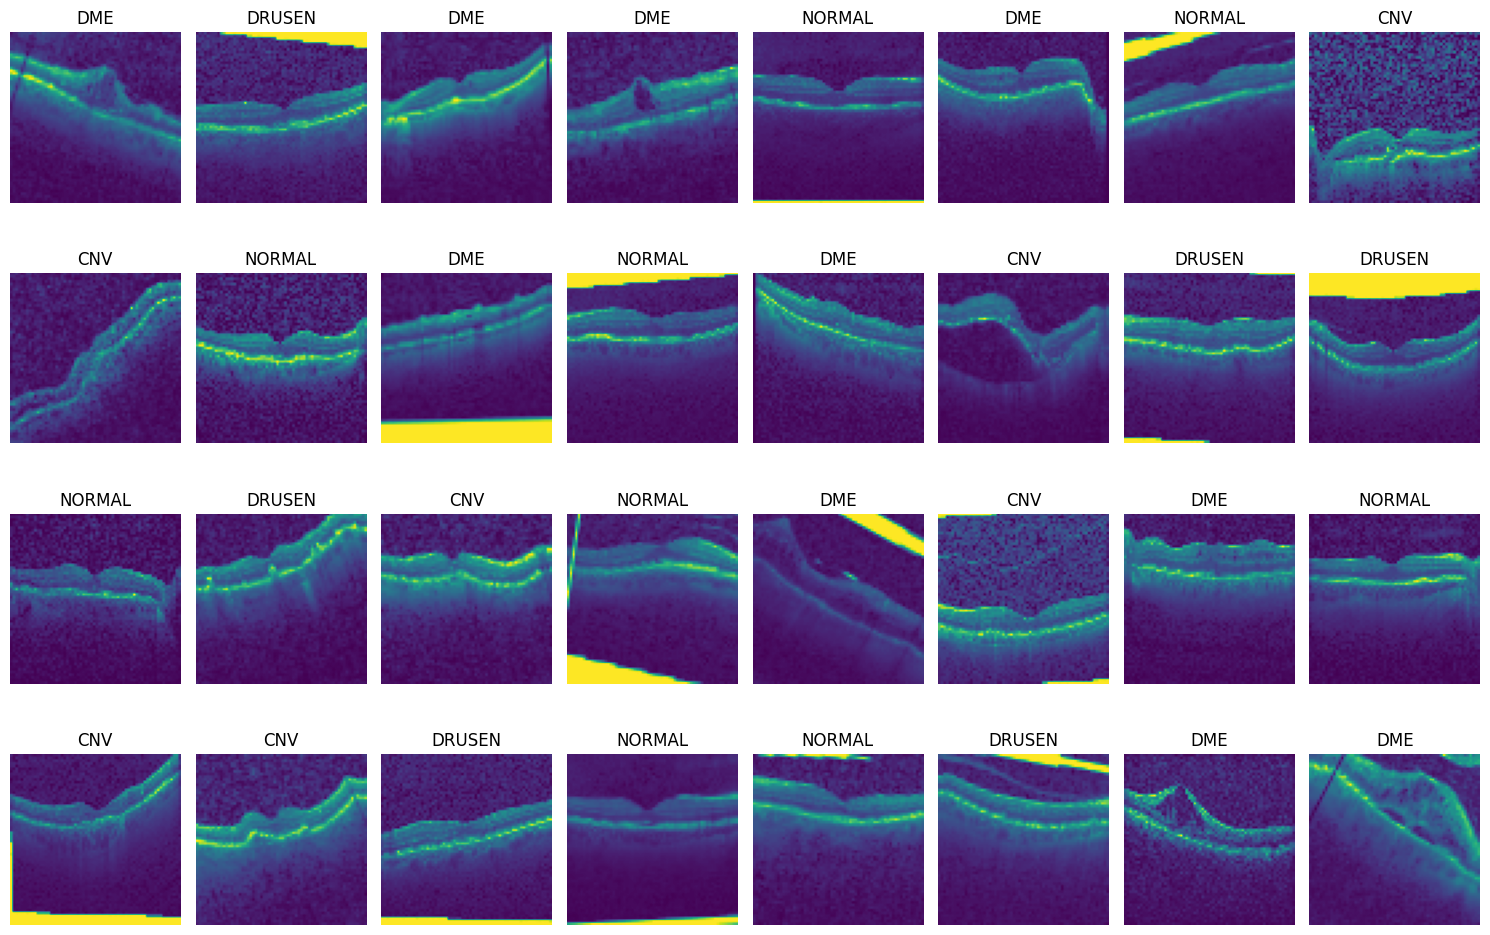

In [14]:
# Get a batch of images and labels from the train_loader
images, labels = next(iter(train_loader))
class_names = train_dataset.classes

print(images.shape)
# Display images in a grid
show_images(images, labels, class_names)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Loading Restnet18 model

In [16]:
resnet_18 = models.resnet18(pretrained=False)

# Modify the classifier (fully connected) layer
num_ftrs = resnet_18.fc.in_features
num_classes = 4  # Replace with the number of classes in your specific problem
resnet_18.fc = nn.Linear(num_ftrs, num_classes)

# Modify the first layer to accept a single-channel image
resnet_18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
resnet_18 = models.resnet18(pretrained=False)

# Modify the classifier (fully connected) layer
num_ftrs = resnet_18.fc.in_features
num_classes = 4  # Replace with the number of classes in your specific problem
resnet_18.fc = nn.Linear(num_ftrs, num_classes)

# Modify the first layer to accept a single-channel image
resnet_18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [18]:
# Move the model to the GPU (if not already)
resnet_18 = resnet_18.to(device)

# Create an example input tensor
input_tensor = torch.randn(1, 1, 64, 64).to(device)
summary(resnet_18, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

### defining learning_rate , criterion , optimizer , scheduler

In [19]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_18.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1 , patience=5)


In [20]:
X, y = next(iter(train_loader))
print(X)
X = X.to(device)
y = y.to(device)


tensor([[[[-0.7569, -0.6706, -0.7725,  ..., -0.7333, -0.8196, -0.7804],
          [-0.8118, -0.6471, -0.6235,  ..., -0.8824, -0.7804, -0.7804],
          [-0.8510, -0.5843, -0.7333,  ..., -0.8118, -0.7255, -0.6784],
          ...,
          [-0.8431, -0.8118, -0.8353,  ..., -0.8275, -0.9216, -0.8196],
          [-0.8902, -0.8745, -0.8824,  ..., -0.8745, -0.8745, -0.8118],
          [-0.8745, -0.9137, -0.7725,  ..., -0.9373, -0.9137, -0.8667]]],


        [[[-0.8510, -0.7255, -0.8353,  ..., -0.7961, -0.9294, -0.9059],
          [-0.9137, -0.8588, -0.8353,  ..., -0.8275, -0.8667, -0.8745],
          [-0.8196, -0.8275, -0.8118,  ..., -0.7882, -0.7176, -0.7961],
          ...,
          [-0.9137, -0.9137, -0.9294,  ..., -0.9294, -0.9137, -0.9451],
          [-0.8980, -0.9608, -0.9294,  ..., -0.9373, -0.9216, -0.9216],
          [-0.8824, -0.9059, -0.9059,  ..., -0.9451, -0.9294, -0.9137]]],


        [[[-0.8902, -0.8588, -0.8667,  ..., -0.3020, -0.3647, -0.4824],
          [-0.8902, -0.898

In [21]:

predictions = resnet_18(X)
print(f"This is the actual prediction my model makes{predictions.shape}")
prediction_classes = torch.argmax(predictions, dim=1)
print(f"This is predictions after argmax:\n{prediction_classes}")
print(f"This is y = {y} \\ and length of y is {len(y)} ")

criterion(predictions,y)

This is the actual prediction my model makestorch.Size([32, 4])
This is predictions after argmax:
tensor([0, 1, 3, 3, 3, 0, 3, 2, 3, 1, 0, 3, 3, 0, 0, 0, 3, 3, 0, 0, 0, 3, 0, 0,
        3, 0, 3, 3, 0, 3, 2, 0], device='cuda:0')
This is y = tensor([3, 2, 3, 0, 3, 2, 3, 1, 2, 2, 0, 2, 0, 2, 0, 3, 0, 0, 3, 3, 0, 3, 1, 0,
        0, 3, 1, 1, 0, 1, 3, 0], device='cuda:0') \ and length of y is 32 


tensor(1.3921, device='cuda:0', grad_fn=<NllLossBackward0>)

## Plotting function

In [63]:


def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    num_epochs = len(train_losses)
    epochs = list(range(1, num_epochs + 1))  # Generate a list of epochs [1, 2, 3, ...]


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation loss
    ax1.plot(epochs,train_losses, label='Training Loss')
    ax1.plot(epochs,val_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot training and validation accuracy
    ax2.plot(epochs,train_accuracies, label='Training Accuracy')
    ax2.plot(epochs,val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()


    plt.show()



### defining my training functions

In [23]:
def Trainfun(model, lossfun, optimizer, train_loader, valid_loader, num_epochs=20):
    # Initializing losses and metrics
    trainLoss = []
    valLoss = []
    trainAcc = []
    valAcc = []
    min_loss = np.inf
    best_model_state=None

    # Loop over epochs
    for epoch in range(num_epochs):
        train_running_loss = 0
        correct_train = 0

        # Set the network to training mode
        model.train()


        train_loader = tqdm(train_loader, desc="Training_batch1")
        # Loop over training data batches
        for X, y in train_loader:
            X = X.to(device,dtype = torch.float32)
            y = y.to(device)

            optimizer.zero_grad()

            # Forward pass
            y_hat = model(X)

            # Calculate the loss
            loss = lossfun(y_hat, y)

            # Backward pass and optimization step

            loss.backward()
            optimizer.step()

            _,predicted_outputs = torch.max(y_hat.data,1)

            correct_train += (predicted_outputs == y).float().sum().item()
            train_running_loss += (loss.data.item() * X.shape[0])

            # Clear GPU memory cache and delete variables
            torch.cuda.empty_cache()
            del X, y, y_hat, loss

        # Calculate average loss and accuracy across batches
        train_epoch_loss = train_running_loss / train_samples
        trainLoss.append(train_epoch_loss)
        train_acc = correct_train / train_samples
        trainAcc.append(train_acc)




        model.eval()
        val_running_loss =0
        correct_val =0

        valid_loader = tqdm(valid_loader, desc="Validation_batch1")
        with torch.no_grad():

          # Loop over validation data batches
          for X, y in valid_loader:
              X = X.to(device,dtype = torch.float32)
              y = y.to(device)

              # Forward pass
              y_hat = model(X)
              loss = criterion(y_hat, y)
              _,predicted_outputs = torch.max(y_hat.data,dim=1)
              correct_val += (predicted_outputs == y).float().sum().item()
              val_running_loss += (loss.data.item()* X.shape[0])

          # Calculate average loss and accuracy across batches
          val_running_loss += (loss.data.item()* X.shape[0])
          val_epoch_loss = val_running_loss / valid_samples
          valLoss.append(val_epoch_loss)
          val_acc = correct_val / valid_samples
          valAcc.append(val_acc)

        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
        print(info.format(epoch + 1, num_epochs, train_epoch_loss, train_acc, val_epoch_loss, val_acc))

        # Updating the learning rate based on validation loss
        scheduler.step(val_epoch_loss)

        if val_epoch_loss < min_loss:
            min_loss = val_epoch_loss
            best_model_state = model.state_dict()


    return trainLoss, valLoss, trainAcc, valAcc, best_model_state


In [24]:
trainLoss_batch1, valLoss_batch1, trainAcc_batch1, valAcc_batch1,best_model_state_batch1 = Trainfun(resnet_18, lossfun= criterion, optimizer = optimizer, train_loader = train_loader, valid_loader = valid_loader, num_epochs=50)


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 107.08it/s]


[Epoch 1/50]: train-loss = 1.116434 | train-acc = 0.495 | val-loss = 0.814048 | val-acc = 0.673


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 112.83it/s]


[Epoch 2/50]: train-loss = 0.813938 | train-acc = 0.669 | val-loss = 0.855275 | val-acc = 0.659


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.71it/s]


[Epoch 3/50]: train-loss = 0.719468 | train-acc = 0.710 | val-loss = 0.665985 | val-acc = 0.741


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.73it/s]


[Epoch 4/50]: train-loss = 0.653141 | train-acc = 0.742 | val-loss = 0.615357 | val-acc = 0.759


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.17it/s]


[Epoch 5/50]: train-loss = 0.608792 | train-acc = 0.763 | val-loss = 0.642703 | val-acc = 0.759


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.94it/s]


[Epoch 6/50]: train-loss = 0.580850 | train-acc = 0.772 | val-loss = 0.538292 | val-acc = 0.801


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.15it/s]


[Epoch 7/50]: train-loss = 0.552811 | train-acc = 0.785 | val-loss = 0.547334 | val-acc = 0.800


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 108.66it/s]


[Epoch 8/50]: train-loss = 0.533645 | train-acc = 0.796 | val-loss = 0.504457 | val-acc = 0.818


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 108.09it/s]


[Epoch 9/50]: train-loss = 0.507963 | train-acc = 0.806 | val-loss = 0.471886 | val-acc = 0.822


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.51it/s]


[Epoch 10/50]: train-loss = 0.487423 | train-acc = 0.811 | val-loss = 0.560850 | val-acc = 0.788


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 106.39it/s]


[Epoch 11/50]: train-loss = 0.472219 | train-acc = 0.821 | val-loss = 0.484510 | val-acc = 0.823


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 111.04it/s]


[Epoch 12/50]: train-loss = 0.453987 | train-acc = 0.824 | val-loss = 0.450176 | val-acc = 0.843


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.95it/s]


[Epoch 13/50]: train-loss = 0.446339 | train-acc = 0.829 | val-loss = 0.422729 | val-acc = 0.846


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.31it/s]


[Epoch 14/50]: train-loss = 0.425936 | train-acc = 0.839 | val-loss = 0.490873 | val-acc = 0.822


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.31it/s]


[Epoch 15/50]: train-loss = 0.418968 | train-acc = 0.841 | val-loss = 0.428658 | val-acc = 0.850


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 106.11it/s]


[Epoch 16/50]: train-loss = 0.398947 | train-acc = 0.847 | val-loss = 0.464298 | val-acc = 0.830


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.05it/s]


[Epoch 17/50]: train-loss = 0.400167 | train-acc = 0.850 | val-loss = 0.443858 | val-acc = 0.843


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 105.91it/s]


[Epoch 18/50]: train-loss = 0.381993 | train-acc = 0.854 | val-loss = 0.483386 | val-acc = 0.825


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.34it/s]


[Epoch 19/50]: train-loss = 0.370081 | train-acc = 0.860 | val-loss = 0.439124 | val-acc = 0.847


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.75it/s]


[Epoch 20/50]: train-loss = 0.313810 | train-acc = 0.882 | val-loss = 0.371007 | val-acc = 0.867


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.47it/s]


[Epoch 21/50]: train-loss = 0.302270 | train-acc = 0.887 | val-loss = 0.368090 | val-acc = 0.869


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 108.91it/s]


[Epoch 22/50]: train-loss = 0.294134 | train-acc = 0.891 | val-loss = 0.365630 | val-acc = 0.869


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.91it/s]


[Epoch 23/50]: train-loss = 0.293473 | train-acc = 0.891 | val-loss = 0.371403 | val-acc = 0.870


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 111.09it/s]


[Epoch 24/50]: train-loss = 0.282201 | train-acc = 0.895 | val-loss = 0.358830 | val-acc = 0.876


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 107.07it/s]


[Epoch 25/50]: train-loss = 0.279832 | train-acc = 0.894 | val-loss = 0.368392 | val-acc = 0.868


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.63it/s]


[Epoch 26/50]: train-loss = 0.272072 | train-acc = 0.901 | val-loss = 0.358777 | val-acc = 0.876


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 112.12it/s]


[Epoch 27/50]: train-loss = 0.272837 | train-acc = 0.901 | val-loss = 0.366110 | val-acc = 0.872


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 107.08it/s]


[Epoch 28/50]: train-loss = 0.275075 | train-acc = 0.901 | val-loss = 0.367674 | val-acc = 0.872


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 102.29it/s]


[Epoch 29/50]: train-loss = 0.266646 | train-acc = 0.901 | val-loss = 0.362570 | val-acc = 0.875


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 111.42it/s]


[Epoch 30/50]: train-loss = 0.259460 | train-acc = 0.903 | val-loss = 0.370664 | val-acc = 0.873


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 112.46it/s]


[Epoch 31/50]: train-loss = 0.267994 | train-acc = 0.902 | val-loss = 0.363931 | val-acc = 0.874


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 105.12it/s]


[Epoch 32/50]: train-loss = 0.259637 | train-acc = 0.905 | val-loss = 0.367931 | val-acc = 0.874


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.25it/s]


[Epoch 33/50]: train-loss = 0.253623 | train-acc = 0.907 | val-loss = 0.365212 | val-acc = 0.874


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 108.64it/s]


[Epoch 34/50]: train-loss = 0.254309 | train-acc = 0.906 | val-loss = 0.362977 | val-acc = 0.873


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.97it/s]


[Epoch 35/50]: train-loss = 0.250423 | train-acc = 0.909 | val-loss = 0.365549 | val-acc = 0.872


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 107.44it/s]


[Epoch 36/50]: train-loss = 0.247513 | train-acc = 0.909 | val-loss = 0.363291 | val-acc = 0.875


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.19it/s]


[Epoch 37/50]: train-loss = 0.245375 | train-acc = 0.912 | val-loss = 0.364625 | val-acc = 0.872


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 102.30it/s]


[Epoch 38/50]: train-loss = 0.252198 | train-acc = 0.910 | val-loss = 0.365220 | val-acc = 0.872


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 107.89it/s]


[Epoch 39/50]: train-loss = 0.246847 | train-acc = 0.910 | val-loss = 0.363328 | val-acc = 0.874


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 108.14it/s]


[Epoch 40/50]: train-loss = 0.244889 | train-acc = 0.911 | val-loss = 0.365377 | val-acc = 0.873


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 106.49it/s]


[Epoch 41/50]: train-loss = 0.243739 | train-acc = 0.913 | val-loss = 0.364822 | val-acc = 0.873


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 108.70it/s]


[Epoch 42/50]: train-loss = 0.244277 | train-acc = 0.910 | val-loss = 0.360524 | val-acc = 0.875


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 108.15it/s]


[Epoch 43/50]: train-loss = 0.249782 | train-acc = 0.909 | val-loss = 0.366707 | val-acc = 0.872


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 111.67it/s]


[Epoch 44/50]: train-loss = 0.247320 | train-acc = 0.909 | val-loss = 0.362923 | val-acc = 0.874


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.30it/s]


[Epoch 45/50]: train-loss = 0.248434 | train-acc = 0.910 | val-loss = 0.366113 | val-acc = 0.874


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 105.86it/s]


[Epoch 46/50]: train-loss = 0.244333 | train-acc = 0.911 | val-loss = 0.360367 | val-acc = 0.874


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.80it/s]


[Epoch 47/50]: train-loss = 0.247950 | train-acc = 0.911 | val-loss = 0.362535 | val-acc = 0.875


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.64it/s]


[Epoch 48/50]: train-loss = 0.249093 | train-acc = 0.910 | val-loss = 0.366873 | val-acc = 0.872


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 110.36it/s]


[Epoch 49/50]: train-loss = 0.245499 | train-acc = 0.909 | val-loss = 0.369807 | val-acc = 0.873


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 109.65it/s]

[Epoch 50/50]: train-loss = 0.243785 | train-acc = 0.911 | val-loss = 0.362895 | val-acc = 0.874


In [25]:
# Save the best model's state dictionary
torch.save(best_model_state_batch1, 'best_resnet_18model_.pth')


In [27]:
# best_resnet_18model = torch.load( 'best_resnet_18model_.pth')

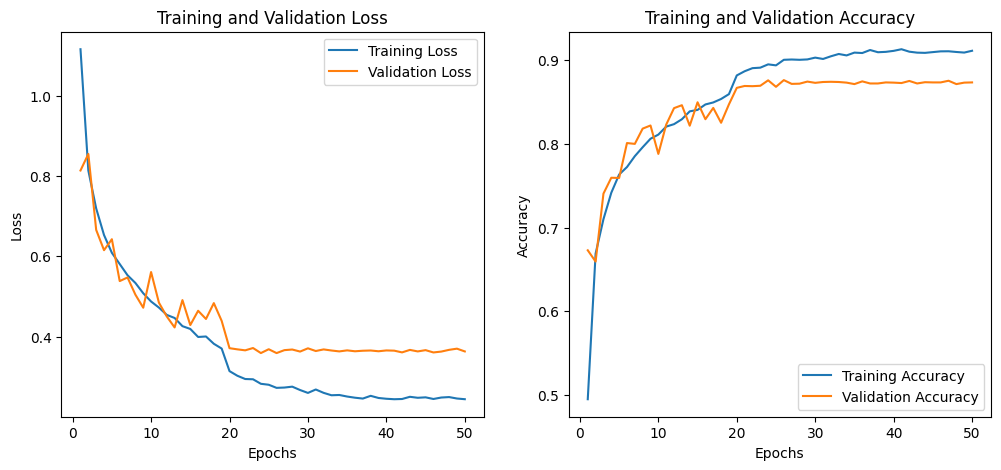

In [64]:
plot_training_results(trainLoss_batch1, valLoss_batch1, trainAcc_batch1, valAcc_batch1)


In [33]:


model_resnet_18 = models.resnet18(pretrained=False)

num_ftrs = model_resnet_18.fc.in_features
num_classes = 4  # Replace with the number of classes in your specific problem
model_resnet_18.fc = nn.Linear(num_ftrs, num_classes)

model_resnet_18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

trained_state_dict = torch.load('best_resnet_18model_.pth')

model_resnet_18.load_state_dict(trained_state_dict)






<All keys matched successfully>

# Preparing Test Images

In [40]:
class CustomTestImgDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.root_dir = root_dir
        self.transform = transform

        # List all the image files in the directory
        image_files = os.listdir(root_dir)

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(root_dir, image_file)
            image = np.array(Image.open(image_path))

            if self.transform is not None:
                augmented = self.transform(image=image)
                image = augmented['image']

            self.data.append(image)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        image = self.data[i]
        return image




In [41]:
test_data = CustomTestImgDataset(root_dir=test_imgs_path, transform=image_transforms['test'])




In [43]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


### prediction on test images

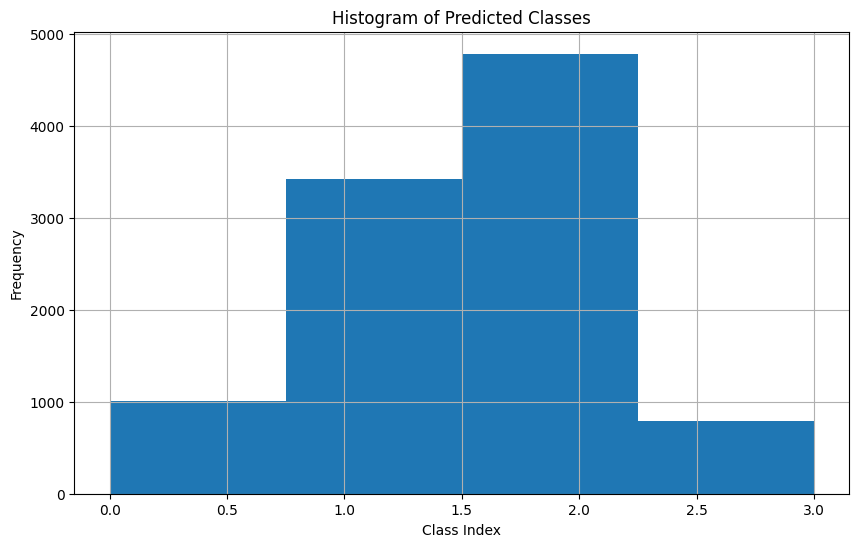

In [44]:


# Initialize an empty list to store prediction classes
predicted_classes = []

# Set the model to evaluation mode
model_resnet_18.eval().cuda()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        # Make predictions.
        prediction = model_resnet_18(inputs)

        # Retrieve prediction indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Convert to a NumPy array and append to the list
        predicted_classes.extend(predicted_class.cpu().numpy())

# Create a histogram of the predicted classes
plt.figure(figsize=(10, 6))
plt.hist(predicted_classes, bins=num_classes)  # Adjust the number of bins if needed
plt.xlabel("Class Index")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Classes")
plt.grid()
plt.show()


In [51]:
class_counts = {'DRUSEN': 0, 'CNV': 0, 'NORMAL': 0, 'DME': 0}

class_labels = ['DRUSEN', 'CNV', 'NORMAL', 'DME']

# Iterate through predicted_classes and update the class counts
for predicted_class in predicted_classes:
    class_counts[class_labels[predicted_class]] += 1

# Print the counts for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} predictions")

Class DRUSEN: 1006 predictions
Class CNV: 3422 predictions
Class NORMAL: 4783 predictions
Class DME: 789 predictions


# Doing the whole training again for Resnet_50

In [53]:
resnet_50 = models.resnet50(pretrained=False)

# Modify the classifier (fully connected) layer
num_ftrs = resnet_50.fc.in_features
num_classes = 4  # Replace with the number of classes in your specific problem
resnet_50.fc = nn.Linear(num_ftrs, num_classes)

# Modify the first layer to accept a single-channel image
resnet_50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [54]:
# Move the model to the GPU (if not already)
resnet_50 = resnet_50.to(device)

# Create an example input tensor
input_tensor = torch.randn(1, 1, 64, 64).to(device)
summary(resnet_50, input_size=(1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,136
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]           4,096
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 256, 16, 16]          16,384
      BatchNorm2d-12          [-1, 256, 16, 16]             512
           Conv2d-13          [-1, 256, 16, 16]          16,384
      BatchNorm2d-14          [-1, 256,

In [56]:
criterion = nn.CrossEntropyLoss()
optimizer_resnet50 = optim.SGD(resnet_50.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0001)
scheduler_resnet50 = lr_scheduler.ReduceLROnPlateau(optimizer_resnet50, factor=0.1 , patience=5)


In [57]:
trainLoss_batch2, valLoss_batch2, trainAcc_batch2, valAcc_batch2,best_model_state_batch1 = Trainfun(resnet_50, lossfun= criterion, optimizer = optimizer_resnet50, train_loader = train_loader, valid_loader = valid_loader, num_epochs=50)


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.02it/s]


[Epoch 1/50]: train-loss = 1.562899 | train-acc = 0.295 | val-loss = 1.602927 | val-acc = 0.366


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.35it/s]


[Epoch 2/50]: train-loss = 1.247383 | train-acc = 0.482 | val-loss = 1.184234 | val-acc = 0.561


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.53it/s]


[Epoch 3/50]: train-loss = 1.006574 | train-acc = 0.599 | val-loss = 0.866015 | val-acc = 0.675


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.70it/s]


[Epoch 4/50]: train-loss = 0.898777 | train-acc = 0.652 | val-loss = 0.926254 | val-acc = 0.674


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.96it/s]


[Epoch 5/50]: train-loss = 0.818518 | train-acc = 0.679 | val-loss = 0.709482 | val-acc = 0.733


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.71it/s]


[Epoch 6/50]: train-loss = 0.752991 | train-acc = 0.707 | val-loss = 0.689062 | val-acc = 0.736


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.24it/s]


[Epoch 7/50]: train-loss = 0.705538 | train-acc = 0.727 | val-loss = 0.830430 | val-acc = 0.707


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.02it/s]


[Epoch 8/50]: train-loss = 0.673497 | train-acc = 0.741 | val-loss = 0.606303 | val-acc = 0.778


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.53it/s]


[Epoch 9/50]: train-loss = 0.632826 | train-acc = 0.757 | val-loss = 0.769476 | val-acc = 0.754


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.24it/s]


[Epoch 10/50]: train-loss = 0.615270 | train-acc = 0.768 | val-loss = 0.548824 | val-acc = 0.798


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 69.30it/s]


[Epoch 11/50]: train-loss = 0.580585 | train-acc = 0.779 | val-loss = 0.547068 | val-acc = 0.800


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 67.49it/s]


[Epoch 12/50]: train-loss = 0.563271 | train-acc = 0.784 | val-loss = 0.578438 | val-acc = 0.800


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 67.53it/s]


[Epoch 13/50]: train-loss = 0.533737 | train-acc = 0.793 | val-loss = 0.504715 | val-acc = 0.817


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 67.82it/s]


[Epoch 14/50]: train-loss = 0.527837 | train-acc = 0.796 | val-loss = 0.483305 | val-acc = 0.825


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.54it/s]


[Epoch 15/50]: train-loss = 0.507860 | train-acc = 0.805 | val-loss = 0.485663 | val-acc = 0.818


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.20it/s]


[Epoch 16/50]: train-loss = 0.496326 | train-acc = 0.810 | val-loss = 0.547590 | val-acc = 0.809


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.87it/s]


[Epoch 17/50]: train-loss = 0.480768 | train-acc = 0.817 | val-loss = 0.588509 | val-acc = 0.786


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.05it/s]


[Epoch 18/50]: train-loss = 0.469508 | train-acc = 0.821 | val-loss = 0.521062 | val-acc = 0.817


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.35it/s]


[Epoch 19/50]: train-loss = 0.451454 | train-acc = 0.829 | val-loss = 0.484399 | val-acc = 0.843


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.32it/s]


[Epoch 20/50]: train-loss = 0.450308 | train-acc = 0.830 | val-loss = 0.502130 | val-acc = 0.829


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.62it/s]


[Epoch 21/50]: train-loss = 0.430332 | train-acc = 0.837 | val-loss = 0.592352 | val-acc = 0.798


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 64.90it/s]


[Epoch 22/50]: train-loss = 0.428196 | train-acc = 0.834 | val-loss = 0.457118 | val-acc = 0.833


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.84it/s]


[Epoch 23/50]: train-loss = 0.421849 | train-acc = 0.841 | val-loss = 0.487847 | val-acc = 0.822


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.12it/s]


[Epoch 24/50]: train-loss = 0.409746 | train-acc = 0.848 | val-loss = 0.429292 | val-acc = 0.841


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.96it/s]


[Epoch 25/50]: train-loss = 0.407979 | train-acc = 0.846 | val-loss = 0.440034 | val-acc = 0.843


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.04it/s]


[Epoch 26/50]: train-loss = 0.396382 | train-acc = 0.849 | val-loss = 0.428400 | val-acc = 0.856


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.69it/s]


[Epoch 27/50]: train-loss = 0.390446 | train-acc = 0.853 | val-loss = 0.418977 | val-acc = 0.842


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.36it/s]


[Epoch 28/50]: train-loss = 0.379758 | train-acc = 0.855 | val-loss = 0.512732 | val-acc = 0.818


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 64.98it/s]


[Epoch 29/50]: train-loss = 0.370887 | train-acc = 0.860 | val-loss = 0.460216 | val-acc = 0.834


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.08it/s]


[Epoch 30/50]: train-loss = 0.372441 | train-acc = 0.861 | val-loss = 0.427851 | val-acc = 0.842


Validation_batch1: 100%|██████████| 125/125 [00:02<00:00, 61.33it/s]


[Epoch 31/50]: train-loss = 0.368128 | train-acc = 0.861 | val-loss = 0.544155 | val-acc = 0.826


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 65.36it/s]


[Epoch 32/50]: train-loss = 0.361356 | train-acc = 0.864 | val-loss = 0.390508 | val-acc = 0.858


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.06it/s]


[Epoch 33/50]: train-loss = 0.351099 | train-acc = 0.866 | val-loss = 0.393754 | val-acc = 0.862


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.03it/s]


[Epoch 34/50]: train-loss = 0.350548 | train-acc = 0.866 | val-loss = 0.472279 | val-acc = 0.836


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 69.25it/s]


[Epoch 35/50]: train-loss = 0.338167 | train-acc = 0.875 | val-loss = 0.416056 | val-acc = 0.855


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 69.05it/s]


[Epoch 36/50]: train-loss = 0.335902 | train-acc = 0.872 | val-loss = 0.430621 | val-acc = 0.856


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 67.85it/s]


[Epoch 37/50]: train-loss = 0.327737 | train-acc = 0.878 | val-loss = 0.551751 | val-acc = 0.834


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 67.06it/s]


[Epoch 38/50]: train-loss = 0.329518 | train-acc = 0.875 | val-loss = 0.409945 | val-acc = 0.859


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.78it/s]


[Epoch 39/50]: train-loss = 0.318756 | train-acc = 0.880 | val-loss = 0.378744 | val-acc = 0.869


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 66.04it/s]


[Epoch 40/50]: train-loss = 0.315714 | train-acc = 0.883 | val-loss = 0.417610 | val-acc = 0.854


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 67.25it/s]


[Epoch 41/50]: train-loss = 0.307658 | train-acc = 0.883 | val-loss = 0.527321 | val-acc = 0.832


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.32it/s]


[Epoch 42/50]: train-loss = 0.305052 | train-acc = 0.884 | val-loss = 0.410867 | val-acc = 0.860


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 67.06it/s]


[Epoch 43/50]: train-loss = 0.294946 | train-acc = 0.888 | val-loss = 0.580899 | val-acc = 0.798


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 69.44it/s]


[Epoch 44/50]: train-loss = 0.294110 | train-acc = 0.888 | val-loss = 0.395694 | val-acc = 0.860


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.61it/s]


[Epoch 45/50]: train-loss = 0.289402 | train-acc = 0.889 | val-loss = 0.418194 | val-acc = 0.858


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 69.43it/s]


[Epoch 46/50]: train-loss = 0.283333 | train-acc = 0.893 | val-loss = 0.466406 | val-acc = 0.854


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.37it/s]


[Epoch 47/50]: train-loss = 0.280092 | train-acc = 0.894 | val-loss = 0.388539 | val-acc = 0.867


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.14it/s]


[Epoch 48/50]: train-loss = 0.277853 | train-acc = 0.895 | val-loss = 0.378741 | val-acc = 0.876


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 68.62it/s]


[Epoch 49/50]: train-loss = 0.275713 | train-acc = 0.900 | val-loss = 0.399418 | val-acc = 0.865


Validation_batch1: 100%|██████████| 125/125 [00:01<00:00, 69.17it/s]

[Epoch 50/50]: train-loss = 0.270888 | train-acc = 0.899 | val-loss = 0.415653 | val-acc = 0.859


### We can see with same setings, Resnet50 is also preforming almost same.

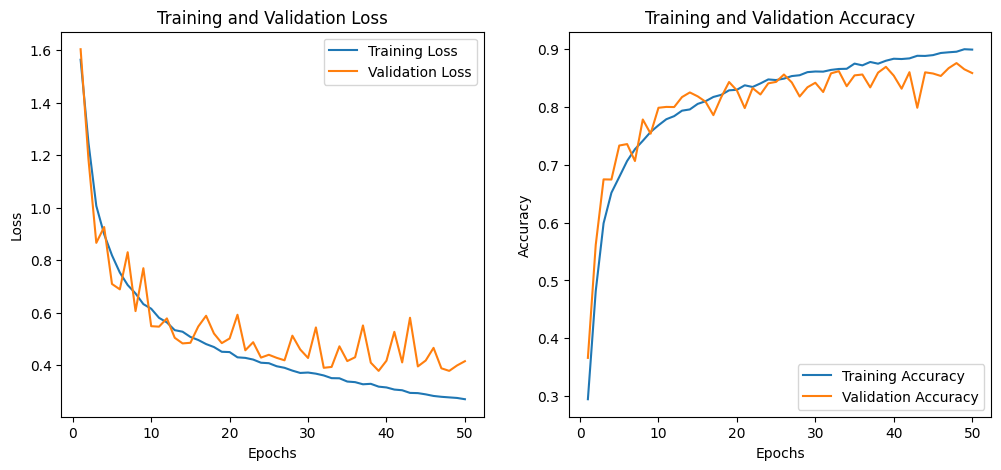

In [65]:
plot_training_results(trainLoss_batch2, valLoss_batch2, trainAcc_batch2, valAcc_batch2)


### Making Prediction on test images

In [58]:
torch.save(best_model_state_batch1, 'best_resnet_50model_.pth')


In [60]:


model_resnet_50 = models.resnet50(pretrained=False)

num_ftrs = model_resnet_50.fc.in_features
num_classes = 4  # Replace with the number of classes in your specific problem
model_resnet_50.fc = nn.Linear(num_ftrs, num_classes)

model_resnet_50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

trained_state_dict = torch.load('best_resnet_50model_.pth')

model_resnet_50.load_state_dict(trained_state_dict)






<All keys matched successfully>

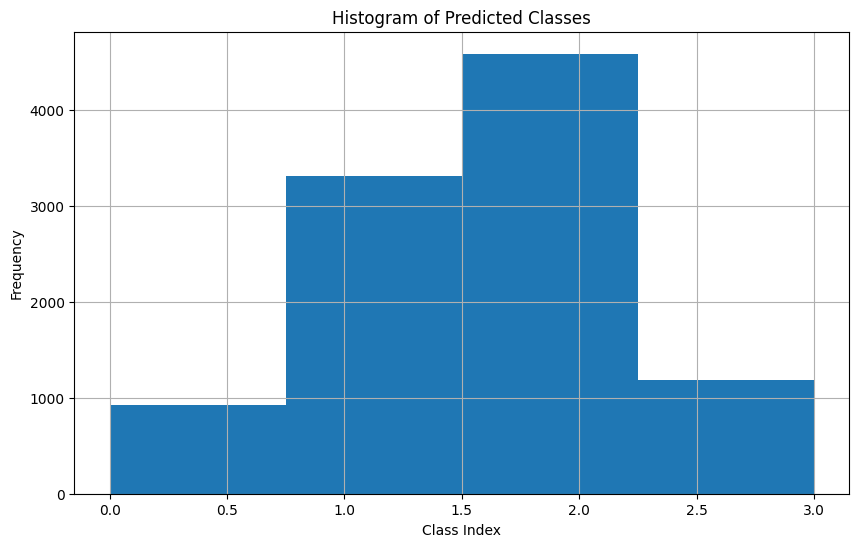

In [61]:


# Initialize an empty list to store prediction classes
predicted_classes = []


model_resnet_50.eval().cuda()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.to(device)
        # Make predictions.
        prediction = model_resnet_50(inputs)

        # Retrieve prediction indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Convert to a NumPy array and append to the list
        predicted_classes.extend(predicted_class.cpu().numpy())

# Create a histogram of the predicted classes
plt.figure(figsize=(10, 6))
plt.hist(predicted_classes, bins=num_classes)  # Adjust the number of bins if needed
plt.xlabel("Class Index")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Classes")
plt.grid()
plt.show()


In [62]:
class_counts = {'DRUSEN': 0, 'CNV': 0, 'NORMAL': 0, 'DME': 0}

class_labels = ['DRUSEN', 'CNV', 'NORMAL', 'DME']

# Iterate through predicted_classes and update the class counts
for predicted_class in predicted_classes:
    class_counts[class_labels[predicted_class]] += 1

# Print the counts for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} predictions")

Class DRUSEN: 927 predictions
Class CNV: 3306 predictions
Class NORMAL: 4581 predictions
Class DME: 1186 predictions
